# 🌱 Analyse Saisonnière des Ratings d'Ingrédients

## Objectif
Analyser les variations saisonnières dans l'appréciation des ingrédients pour identifier :
- Les ingrédients avec des préférences saisonnières marquées
- Les patterns de consommation selon les saisons
- Les opportunités de menu saisonnier

## Méthodologie
- **Test statistique** : ANOVA pour comparer les moyennes entre saisons
- **Post-hoc** : Test de Tukey pour identifier les différences par paires
- **Agrégation** : Ratings moyens par saison et ingrédient
- **Visualisation** : Box plots et radar charts saisonniers
- **Seuil de significativité** : p < 0.05

## Définition des Saisons
- **Printemps** : Mars, Avril, Mai
- **Été** : Juin, Juillet, Août  
- **Automne** : Septembre, Octobre, Novembre
- **Hiver** : Décembre, Janvier, Février

In [2]:
# Import des bibliothèques nécessaires
import sys
from pathlib import Path

# Trouve automatiquement le dossier qui contient '00_eda/_data_utils'
cwd = Path.cwd()
repo_root = cwd
while repo_root != repo_root.parent:
    if (repo_root / '00_eda' / '_data_utils').exists():
        break
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root / '00_eda'))

# 🎯 Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from _data_utils import *

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, tukey_hsd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Couleurs pour les saisons
SEASON_COLORS = {
    'Printemps': '#90EE90',  # Vert clair
    'Été': '#FFD700',        # Jaune doré
    'Automne': '#FF8C00',    # Orange
    'Hiver': '#87CEEB'       # Bleu ciel
}

print("📚 Toutes les bibliothèques importées avec succès !")
print("🌱 Analyse saisonnière prête à démarrer !")

✅ _data_utils module chargé (common + ratings + recipes)
📚 Toutes les bibliothèques importées avec succès !
🌱 Analyse saisonnière prête à démarrer !


In [3]:
# Fonction pour mapper les mois aux saisons
def get_season(month):
    """
    Convertit un numéro de mois en saison
    """
    if month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return 'Été'
    elif month in [9, 10, 11]:
        return 'Automne'
    else:  # [12, 1, 2]
        return 'Hiver'

print('✅ Fonction de mapping saisons définie')

✅ Fonction de mapping saisons définie


In [4]:
# Chargement des données pour analyse saisonnière
print('🔄 Chargement des données...')

# 🎯 Ingrédients avec VRAIE SAISONNALITÉ (sélection optimisée)
# Stratégie: Sélectionner des ingrédients avec variations naturelles selon les saisons
target_ingredients = [
    # 🌱 PRINTEMPS
    'asparagus',         # Pic printemps (Avril-Mai)
    'peas',              # Pic printemps (Avril-Juin)
    'strawberries',      # Pic printemps/été (Mai-Juin)
    'rhubarb',           # Pic printemps (Avril-Mai)
    
    # ☀️ ÉTÉ  
    'tomatoes',          # Pic été (Juillet-Août)
    'zucchini',          # Pic été (Juin-Août)
    'basil',             # Herbe d'été (Juin-Septembre)
    'corn',              # Pic été (Juillet-Août)
    
    # 🍂 AUTOMNE
    'butternut squash',  # Pic automne (Octobre-Novembre)
    'pumpkin',           # Pic automne (Octobre-Novembre)
    'brussels sprouts',  # Pic automne/hiver (Septembre-Février)
    'sweet potato',      # Pic automne (Septembre-Novembre)
    
    # ❄️ HIVER
    'kale',              # Résistant au froid (Novembre-Mars)
    'cabbage',           # Légume d'hiver (Décembre-Mars)
    'cranberries',       # Pic hiver (Novembre-Décembre)
    'lemon'              # Agrumes hiver (Décembre-Février)
]

print(f'📋 Ingrédients saisonniers sélectionnés: {len(target_ingredients)} ingrédients')
print(f'   🌱 Printemps: asparagus, peas, strawberries, rhubarb')
print(f'   ☀️  Été: tomatoes, zucchini, basil, corn')
print(f'   🍂 Automne: butternut squash, pumpkin, brussels sprouts, sweet potato')
print(f'   ❄️  Hiver: kale, cabbage, cranberries, lemon')

# Chargement du dataset
df = load_ingredient_ratings(target_ingredients)
print(f'\n✅ Dataset chargé: {df.shape[0]:,} interactions')
print(f'📅 Période: {df["date"].min()} → {df["date"].max()}')

# Ajout de la colonne saison
df = df.with_columns([
    pl.col('date').dt.month().alias('month')
]).with_columns([
    pl.col('month').map_elements(get_season, return_dtype=pl.Utf8).alias('season')
])

print('\n📊 Distribution par saison:')
season_dist = df.group_by('season').agg(pl.len().alias('count')).sort('count', descending=True)
print(season_dist)

# Statistiques de disponibilité par ingrédient
print('\n📈 Disponibilité des ingrédients saisonniers:')
ingredient_stats = df.group_by('ingredient_name').agg([
    pl.len().alias('n_ratings'),
    pl.col('date').min().alias('first_date'),
    pl.col('date').max().alias('last_date')
]).sort('n_ratings', descending=True)
print(ingredient_stats)

print('\n📊 Aperçu des données avec saisons:')
print(df.select(['date', 'month', 'season', 'ingredient_name', 'rating']).head())

🔄 Chargement des données...
📋 Ingrédients saisonniers sélectionnés: 16 ingrédients
   🌱 Printemps: asparagus, peas, strawberries, rhubarb
   ☀️  Été: tomatoes, zucchini, basil, corn
   🍂 Automne: butternut squash, pumpkin, brussels sprouts, sweet potato
   ❄️  Hiver: kale, cabbage, cranberries, lemon
✅ Données chargées: 152,619 interactions pour 16 ingrédients

✅ Dataset chargé: 152,619 interactions
📅 Période: 2000-03-13 → 2018-12-19

📊 Distribution par saison:
shape: (4, 2)
┌───────────┬───────┐
│ season    ┆ count │
│ ---       ┆ ---   │
│ str       ┆ u32   │
╞═══════════╪═══════╡
│ Été       ┆ 42845 │
│ Printemps ┆ 37597 │
│ Automne   ┆ 37121 │
│ Hiver     ┆ 35056 │
└───────────┴───────┘

📈 Disponibilité des ingrédients saisonniers:
shape: (16, 4)
┌──────────────────┬───────────┬────────────┬────────────┐
│ ingredient_name  ┆ n_ratings ┆ first_date ┆ last_date  │
│ ---              ┆ ---       ┆ ---        ┆ ---        │
│ str              ┆ u32       ┆ date       ┆ date       │
╞══

In [5]:
# Agrégation des données par saison et ingrédient
print('🔧 Agrégation des données saisonnières...')

df_seasonal = df.group_by(['ingredient_name', 'season']).agg([
    pl.col('rating').mean().alias('avg_rating'),
    pl.col('rating').count().alias('n_ratings'),
    pl.col('rating').std().alias('std_rating'),
    pl.col('rating').median().alias('median_rating')
]).sort(['ingredient_name', 'season'])

print(f'✅ Données agrégées: {df_seasonal.shape[0]} points saison-ingrédient')

# Vérification de la couverture saisonnière par ingrédient
season_coverage = df_seasonal.group_by('ingredient_name').agg([
    pl.col('season').n_unique().alias('seasons_covered'),
    pl.col('n_ratings').sum().alias('total_ratings')
]).sort('total_ratings', descending=True)

print('\n📈 Couverture saisonnière par ingrédient:')
print(season_coverage)

# Filtrer les ingrédients avec couverture complète (4 saisons)
complete_ingredients = season_coverage.filter(
    pl.col('seasons_covered') == 4
)['ingredient_name'].to_list()

print(f'\n🎯 Ingrédients avec couverture complète (4 saisons): {len(complete_ingredients)}')
print(f'Ingrédients: {complete_ingredients}')

🔧 Agrégation des données saisonnières...
✅ Données agrégées: 64 points saison-ingrédient

📈 Couverture saisonnière par ingrédient:
shape: (16, 3)
┌──────────────────┬─────────────────┬───────────────┐
│ ingredient_name  ┆ seasons_covered ┆ total_ratings │
│ ---              ┆ ---             ┆ ---           │
│ str              ┆ u32             ┆ u32           │
╞══════════════════╪═════════════════╪═══════════════╡
│ tomatoes         ┆ 4               ┆ 47869         │
│ lemon            ┆ 4               ┆ 27689         │
│ zucchini         ┆ 4               ┆ 18819         │
│ basil            ┆ 4               ┆ 14110         │
│ cabbage          ┆ 4               ┆ 9090          │
│ …                ┆ …               ┆ …             │
│ peas             ┆ 4               ┆ 2147          │
│ cranberries      ┆ 4               ┆ 1932          │
│ rhubarb          ┆ 4               ┆ 1866          │
│ sweet potato     ┆ 4               ┆ 1694          │
│ brussels sprouts ┆ 4       

In [6]:
# Test ANOVA pour détecter les différences saisonnières
print('🔍 Test ANOVA pour les différences saisonnières...')

anova_results = []

for ingredient in complete_ingredients:
    # Données pour cet ingrédient par saison
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    # Extraction des ratings par saison
    spring_ratings = ingredient_data.filter(pl.col('season') == 'Printemps')['rating'].to_list()
    summer_ratings = ingredient_data.filter(pl.col('season') == 'Été')['rating'].to_list()
    autumn_ratings = ingredient_data.filter(pl.col('season') == 'Automne')['rating'].to_list()
    winter_ratings = ingredient_data.filter(pl.col('season') == 'Hiver')['rating'].to_list()
    
    # Test ANOVA
    if all(len(ratings) > 0 for ratings in [spring_ratings, summer_ratings, autumn_ratings, winter_ratings]):
        f_stat, p_value = f_oneway(spring_ratings, summer_ratings, autumn_ratings, winter_ratings)
        
        # Calcul des moyennes par saison
        season_means = {
            'spring_mean': np.mean(spring_ratings),
            'summer_mean': np.mean(summer_ratings),
            'autumn_mean': np.mean(autumn_ratings),
            'winter_mean': np.mean(winter_ratings)
        }
        
        # Identification de la meilleure et pire saison
        best_season = max(season_means, key=season_means.get).replace('_mean', '')
        worst_season = min(season_means, key=season_means.get).replace('_mean', '')
        
        anova_results.append({
            'ingredient': ingredient,
            'f_statistic': f_stat,
            'p_value': p_value,
            'significant': p_value < 0.05,  # Booléen pur
            'spring_avg': season_means['spring_mean'],
            'summer_avg': season_means['summer_mean'],
            'autumn_avg': season_means['autumn_mean'],
            'winter_avg': season_means['winter_mean'],
            'best_season': best_season.title(),
            'worst_season': worst_season.title(),
            'seasonal_range': max(season_means.values()) - min(season_means.values())
        })

# Conversion en DataFrame Polars
anova_df = pl.DataFrame(anova_results).sort('p_value')

print('\n📊 Résultats ANOVA pour les différences saisonnières:')
print(anova_df.select(['ingredient', 'f_statistic', 'p_value', 'significant', 'best_season', 'seasonal_range']))

# Résumé des différences significatives
significant_seasonal = anova_df.filter(pl.col('significant') == True)
print(f'\n🎯 Ingrédients avec variations saisonnières significatives: {len(significant_seasonal)}/{len(complete_ingredients)}')

if len(significant_seasonal) > 0:
    print('\nVariations saisonnières significatives:')
    for row in significant_seasonal.iter_rows(named=True):
        print(f"🌱 {row['ingredient']}: Meilleure saison = {row['best_season']} " +
              f"(amplitude = {row['seasonal_range']:.4f}, p={row['p_value']:.4f})")
else:
    print('➡️ Aucune variation saisonnière significative détectée')

🔍 Test ANOVA pour les différences saisonnières...

📊 Résultats ANOVA pour les différences saisonnières:
shape: (16, 6)
┌──────────────────┬─────────────┬──────────┬─────────────┬─────────────┬────────────────┐
│ ingredient       ┆ f_statistic ┆ p_value  ┆ significant ┆ best_season ┆ seasonal_range │
│ ---              ┆ ---         ┆ ---      ┆ ---         ┆ ---         ┆ ---            │
│ str              ┆ f64         ┆ f64      ┆ f64         ┆ str         ┆ f64            │
╞══════════════════╪═════════════╪══════════╪═════════════╪═════════════╪════════════════╡
│ tomatoes         ┆ 4.961961    ┆ 0.001919 ┆ 1.0         ┆ Summer      ┆ 0.031037       │
│ lemon            ┆ 3.859172    ┆ 0.008989 ┆ 1.0         ┆ Summer      ┆ 0.038943       │
│ brussels sprouts ┆ 3.190635    ┆ 0.022909 ┆ 1.0         ┆ Winter      ┆ 0.125855       │
│ corn             ┆ 2.801316    ┆ 0.038426 ┆ 1.0         ┆ Summer      ┆ 0.056164       │
│ kale             ┆ 2.055147    ┆ 0.104153 ┆ 0.0         ┆ Wi

In [7]:
# Analyse détaillée par paires pour les ingrédients significatifs
print('🔍 Tests par paires (Mann-Whitney U) pour les différences saisonnières...')

from scipy.stats import mannwhitneyu

tukey_results = {}

for ingredient in significant_seasonal['ingredient'].to_list():
    print(f'\n📊 Analyse détaillée pour {ingredient}:')
    
    # Préparation des données par saison
    ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
    
    seasons = ['Printemps', 'Été', 'Automne', 'Hiver']
    season_data = {}
    
    for season in seasons:
        season_ratings = ingredient_data.filter(pl.col('season') == season)['rating'].to_list()
        season_data[season] = season_ratings
        print(f"   {season}: {len(season_ratings)} ratings, moyenne = {np.mean(season_ratings):.4f}")
    
    # Test par paires avec Mann-Whitney U
    print(f'\n   🔍 Comparaisons par paires significatives (p<0.05):')
    significant_pairs = []
    
    for i, season1 in enumerate(seasons):
        for j, season2 in enumerate(seasons[i+1:], i+1):
            try:
                u_stat, p_value = mannwhitneyu(season_data[season1], season_data[season2], alternative='two-sided')
                if p_value < 0.05:
                    mean_diff = np.mean(season_data[season1]) - np.mean(season_data[season2])
                    direction = '>' if mean_diff > 0 else '<'
                    significant_pairs.append(f"   → {season1} {direction} {season2}: Δ={mean_diff:+.4f} (p={p_value:.4f})")
            except Exception as e:
                continue
    
    if significant_pairs:
        for pair in significant_pairs:
            print(pair)
    else:
        print('   → Aucune différence par paires significative détectée')
    
    tukey_results[ingredient] = significant_pairs

print(f'\n✅ Tests par paires terminés pour {len(tukey_results)} ingrédients')

🔍 Tests par paires (Mann-Whitney U) pour les différences saisonnières...

📊 Analyse détaillée pour tomatoes:
   Printemps: 11471 ratings, moyenne = 4.6932
   Été: 14658 ratings, moyenne = 4.7060
   Automne: 11422 ratings, moyenne = 4.6749
   Hiver: 10318 ratings, moyenne = 4.6906

   🔍 Comparaisons par paires significatives (p<0.05):
   → Été > Automne: Δ=+0.0310 (p=0.0010)
   → Automne < Hiver: Δ=-0.0157 (p=0.0433)

📊 Analyse détaillée pour lemon:
   Printemps: 7224 ratings, moyenne = 4.6930
   Été: 7890 ratings, moyenne = 4.7134
   Automne: 6006 ratings, moyenne = 4.6745
   Hiver: 6569 ratings, moyenne = 4.6916

   🔍 Comparaisons par paires significatives (p<0.05):
   → Été > Automne: Δ=+0.0389 (p=0.0230)

📊 Analyse détaillée pour brussels sprouts:
   Printemps: 314 ratings, moyenne = 4.7229
   Été: 184 ratings, moyenne = 4.7717
   Automne: 375 ratings, moyenne = 4.6640
   Hiver: 414 ratings, moyenne = 4.7899

   🔍 Comparaisons par paires significatives (p<0.05):
   → Automne < Hiver

In [8]:
# 📋 RAPPORT DÉTAILLÉ DES VARIATIONS SAISONNIÈRES
print('='*80)
print('📋 RAPPORT DÉTAILLÉ - ANALYSE SAISONNIÈRE DES INGRÉDIENTS')
print('='*80)

print('\n🔍 DONNÉES ANALYSÉES:')
print(f'   • Période: {df["date"].min()} → {df["date"].max()}')
print(f'   • Total interactions: {df.shape[0]:,}')
print(f'   • Ingrédients analysés: {len(target_ingredients)}')
print(f'   • Ingrédients avec couverture complète (4 saisons): {len(complete_ingredients)}')

print('\n📊 DISTRIBUTION PAR SAISON:')
season_summary = df.group_by('season').agg([
    pl.len().alias('n_ratings'),
    pl.col('rating').mean().alias('avg_rating'),
    (pl.col('rating') == 5).sum().alias('count_5stars')
]).with_columns([
    (pl.col('count_5stars') / pl.col('n_ratings') * 100).alias('pct_5stars')
]).sort('season')

for row in season_summary.iter_rows(named=True):
    season_emoji = {'Printemps': '🌱', 'Été': '☀️', 'Automne': '🍂', 'Hiver': '❄️'}
    emoji = season_emoji.get(row['season'], '🌿')
    print(f"   {emoji} {row['season']:12s}: {row['n_ratings']:>8,} ratings | " +
          f"Avg: {row['avg_rating']:.4f} | 5★: {row['pct_5stars']:.2f}%")

print('\n📈 RÉSULTATS ANOVA (Variations Saisonnières):')
print(f'   • Tests réalisés: {len(anova_df)} ingrédients')
print(f'   • Variations significatives (p<0.05): {len(significant_seasonal)}/{len(anova_df)}')

if len(significant_seasonal) > 0:
    print(f'   • Taux de significativité: {len(significant_seasonal)/len(anova_df)*100:.1f}%')
    
    # Statistiques des amplitudes
    amplitude_stats = significant_seasonal.select('seasonal_range')
    print('\n📊 STATISTIQUES DES AMPLITUDES:')
    print(f'   • Moyenne: {amplitude_stats.mean().item():.4f} points')
    print(f'   • Médiane: {amplitude_stats.median().item():.4f} points')
    print(f'   • Maximum: {amplitude_stats.max().item():.4f} points')
    print(f'   • Minimum: {amplitude_stats.min().item():.4f} points')
    
    # Calcul du % de variation moyen
    avg_amplitude = amplitude_stats.mean().item()
    avg_rating_overall = df['rating'].mean()
    pct_variation = (avg_amplitude / avg_rating_overall) * 100
    print(f'   • % de variation moyen: {pct_variation:.2f}%')
    
    # Groupement par saison préférée
    print('\n🏆 RÉPARTITION DES SAISONS PRÉFÉRÉES:')
    seasonal_preferences = significant_seasonal.group_by('best_season').agg([
        pl.col('ingredient').count().alias('n_ingredients'),
        pl.col('ingredient').alias('ingredients_list')
    ]).sort('n_ingredients', descending=True)
    
    for row in seasonal_preferences.iter_rows(named=True):
        season_emoji = {'Printemps': '🌱', 'Été': '☀️', 'Automne': '🍂', 'Hiver': '❄️'}
        emoji = season_emoji.get(row['best_season'], '🌿')
        print(f"\n   {emoji} {row['best_season']} ({row['n_ingredients']} ingrédients):")
        for ingredient in row['ingredients_list']:
            ing_stats = significant_seasonal.filter(pl.col('ingredient') == ingredient).row(0, named=True)
            amplitude = ing_stats['seasonal_range']
            worst_season = ing_stats['worst_season']
            pct_change = (amplitude / avg_rating_overall) * 100
            print(f"      • {ingredient:20s}: Δ={amplitude:.4f} ({pct_change:+.2f}%) | " +
                  f"Pire: {worst_season}")
    
    # Top 5 ingrédients les plus variables
    print('\n🥇 TOP 5 INGRÉDIENTS LES PLUS VARIABLES:')
    top5 = significant_seasonal.sort('seasonal_range', descending=True).head(5)
    
    for i, row in enumerate(top5.iter_rows(named=True), 1):
        best_emoji = {'Printemps': '🌱', 'Été': '☀️', 'Automne': '🍂', 'Hiver': '❄️'}
        emoji = best_emoji.get(row['best_season'], '🌿')
        pct_change = (row['seasonal_range'] / avg_rating_overall) * 100
        
        print(f"\n   {i}. {row['ingredient'].upper()}")
        print(f"      • Amplitude: {row['seasonal_range']:.4f} points ({pct_change:+.2f}%)")
        print(f"      • {emoji} Meilleure saison: {row['best_season']} ({row[row['best_season'].lower() + '_avg']:.4f})")
        print(f"      • Pire saison: {row['worst_season']} ({row[row['worst_season'].lower() + '_avg']:.4f})")
        print(f"      • p-value ANOVA: {row['p_value']:.6f} {'***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*'}")

else:
    print('   ⚠️  Aucune variation saisonnière significative détectée')
    print('   → Vérifier sélection des ingrédients (privilégier ingrédients saisonniers)')

print('\n' + '='*80)
print('✅ Rapport détaillé terminé')
print('='*80)

📋 RAPPORT DÉTAILLÉ - ANALYSE SAISONNIÈRE DES INGRÉDIENTS

🔍 DONNÉES ANALYSÉES:
   • Période: 2000-03-13 → 2018-12-19
   • Total interactions: 152,619
   • Ingrédients analysés: 16
   • Ingrédients avec couverture complète (4 saisons): 16

📊 DISTRIBUTION PAR SAISON:
   🍂 Automne     :   37,121 ratings | Avg: 4.6692 | 5★: 75.80%
   ❄️ Hiver       :   35,056 ratings | Avg: 4.6740 | 5★: 76.14%
   🌱 Printemps   :   37,597 ratings | Avg: 4.6832 | 5★: 76.36%
   ☀️ Été         :   42,845 ratings | Avg: 4.6956 | 5★: 76.97%

📈 RÉSULTATS ANOVA (Variations Saisonnières):
   • Tests réalisés: 16 ingrédients
   • Variations significatives (p<0.05): 4/16
   • Taux de significativité: 25.0%

📊 STATISTIQUES DES AMPLITUDES:
   • Moyenne: 0.0630 points
   • Médiane: 0.0476 points
   • Maximum: 0.1259 points
   • Minimum: 0.0310 points
   • % de variation moyen: 1.35%

🏆 RÉPARTITION DES SAISONS PRÉFÉRÉES:

   🌿 Summer (3 ingrédients):
      • tomatoes            : Δ=0.0310 (+0.66%) | Pire: Autumn
      • 

📊 Création des visualisations saisonnières optimisées...


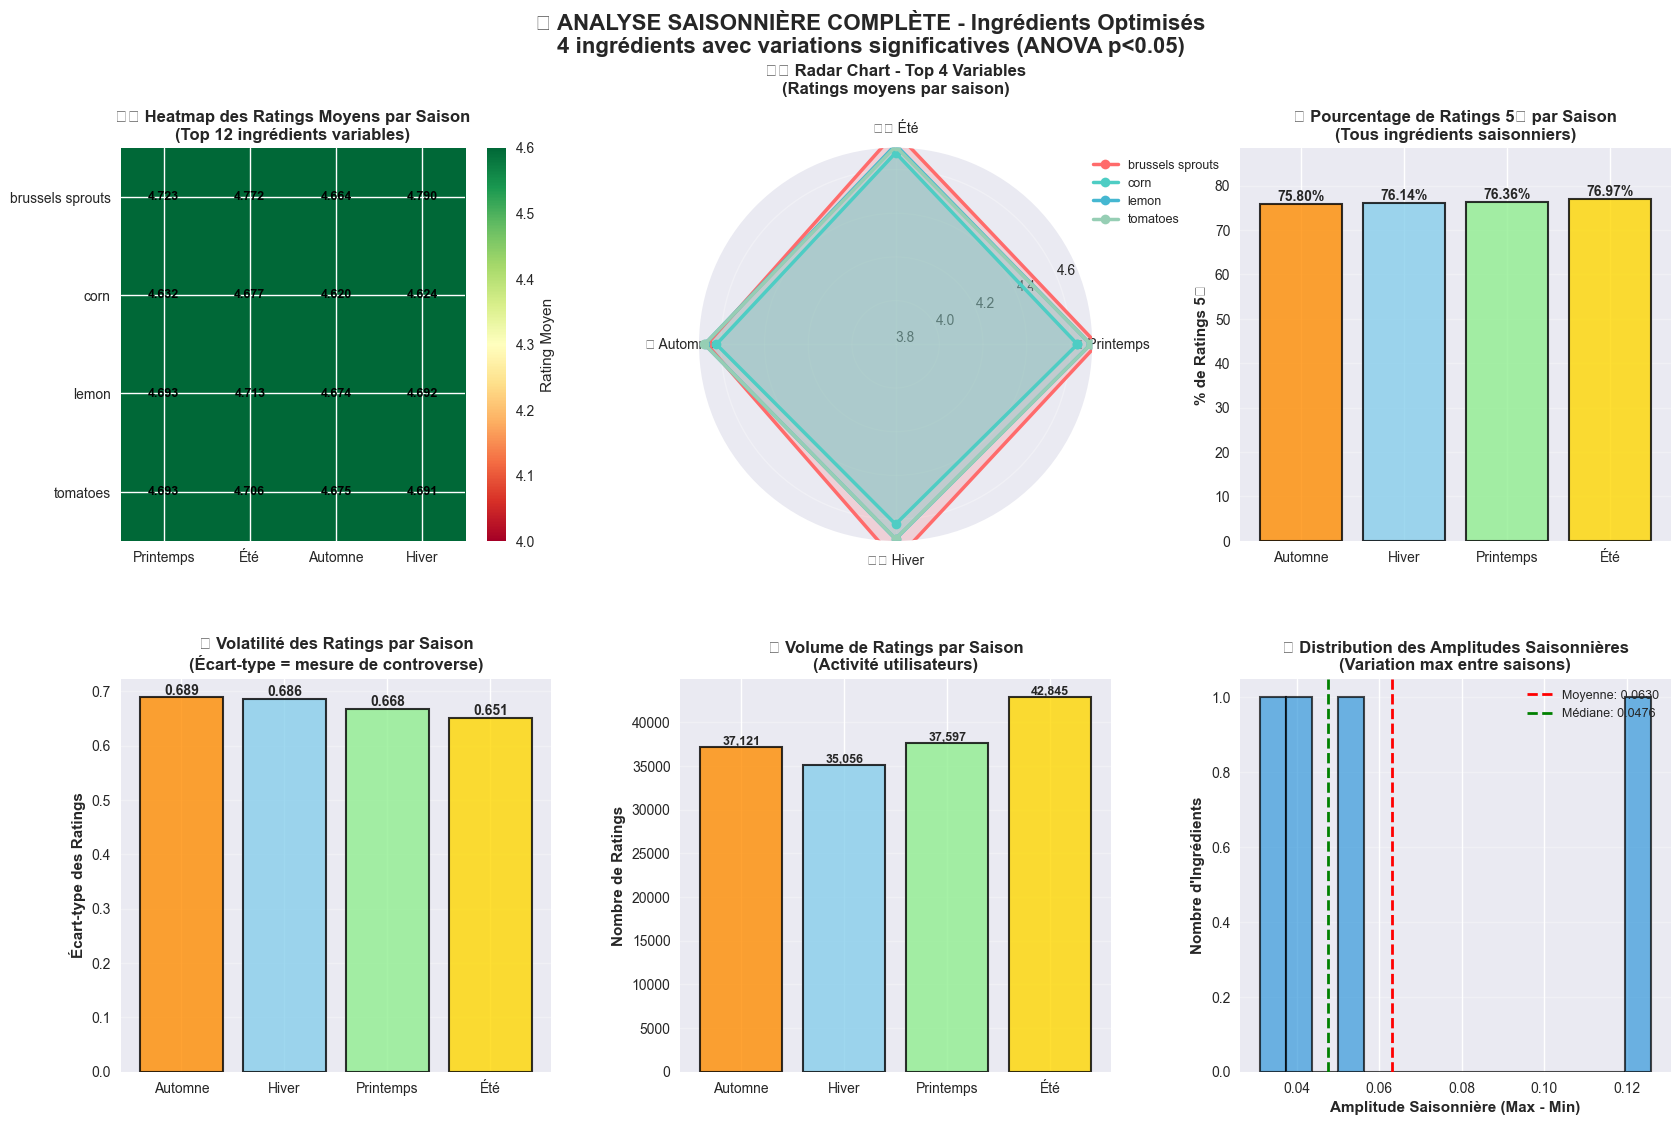

✅ Visualisations saisonnières optimisées créées (GridSpec 2×3)


In [9]:
# 📊 VISUALISATION PRINCIPALE - GridSpec 2×3 Optimisé
print('📊 Création des visualisations saisonnières optimisées...')

from matplotlib.gridspec import GridSpec

if len(significant_seasonal) > 0:
    # Création de la figure avec GridSpec
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3)
    
    # --- GRAPHIQUE 1: Heatmap % Change par Saison ---
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Préparation des données pour heatmap
    heatmap_data = []
    heatmap_ingredients = significant_seasonal.sort('seasonal_range', descending=True)['ingredient'].to_list()[:12]
    
    seasons_order = ['Printemps', 'Été', 'Automne', 'Hiver']
    for ingredient in heatmap_ingredients:
        ingredient_row = anova_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        row_data = [
            ingredient_row['spring_avg'],
            ingredient_row['summer_avg'],
            ingredient_row['autumn_avg'],
            ingredient_row['winter_avg']
        ]
        heatmap_data.append(row_data)
    
    # Heatmap avec annotations
    im = ax1.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=4.0, vmax=4.6)
    ax1.set_xticks(range(len(seasons_order)))
    ax1.set_xticklabels(seasons_order)
    ax1.set_yticks(range(len(heatmap_ingredients)))
    ax1.set_yticklabels(heatmap_ingredients)
    
    # Annotations avec valeurs
    for i in range(len(heatmap_ingredients)):
        for j in range(len(seasons_order)):
            value = heatmap_data[i][j]
            text_color = 'white' if value < 4.25 else 'black'
            ax1.text(j, i, f'{value:.3f}', ha="center", va="center", 
                    color=text_color, fontweight='bold', fontsize=9)
    
    ax1.set_title('🌡️ Heatmap des Ratings Moyens par Saison\n(Top 12 ingrédients variables)', 
                 fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax1, label='Rating Moyen')
    
    # --- GRAPHIQUE 2: Radar Chart Zoomé par Saison ---
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    
    import math
    angles = [n / float(len(seasons_order)) * 2 * math.pi for n in range(len(seasons_order))]
    angles += angles[:1]
    
    # Top 4 ingrédients les plus variables
    radar_ingredients = significant_seasonal.sort('seasonal_range', descending=True).head(4)['ingredient'].to_list()
    colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for i, ingredient in enumerate(radar_ingredients):
        ingredient_row = anova_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        values = [
            ingredient_row['spring_avg'],
            ingredient_row['summer_avg'],
            ingredient_row['autumn_avg'],
            ingredient_row['winter_avg']
        ]
        values += values[:1]
        
        ax2.plot(angles, values, 'o-', linewidth=2.5, label=ingredient, color=colors_radar[i])
        ax2.fill(angles, values, alpha=0.2, color=colors_radar[i])
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(['🌱 Printemps', '☀️ Été', '🍂 Automne', '❄️ Hiver'], fontsize=10)
    ax2.set_ylim(3.8, 4.7)
    ax2.set_title('🕷️ Radar Chart - Top 4 Variables\n(Ratings moyens par saison)', 
                 fontsize=12, fontweight='bold', pad=20)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0), fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # --- GRAPHIQUE 3: % de Ratings 5★ par Saison ---
    ax3 = fig.add_subplot(gs[0, 2])
    
    seasonal_5stars = df.group_by('season').agg([
        (pl.col('rating') == 5).sum().alias('count_5stars'),
        pl.len().alias('total_ratings')
    ]).with_columns([
        (pl.col('count_5stars') / pl.col('total_ratings') * 100).alias('pct_5stars')
    ]).sort('season')
    
    seasons_plot = seasonal_5stars['season'].to_list()
    pct_5stars = seasonal_5stars['pct_5stars'].to_list()
    
    bars = ax3.bar(range(len(seasons_plot)), pct_5stars, 
                   color=[SEASON_COLORS.get(s, '#666666') for s in seasons_plot],
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Labels avec valeurs
    for i, (bar, pct) in enumerate(zip(bars, pct_5stars)):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax3.set_xticks(range(len(seasons_plot)))
    ax3.set_xticklabels(seasons_plot)
    ax3.set_ylabel('% de Ratings 5★', fontweight='bold')
    ax3.set_title('⭐ Pourcentage de Ratings 5★ par Saison\n(Tous ingrédients saisonniers)', 
                 fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_ylim(0, max(pct_5stars) * 1.15)
    
    # --- GRAPHIQUE 4: Volatilité (Std) par Saison ---
    ax4 = fig.add_subplot(gs[1, 0])
    
    seasonal_volatility = df.group_by('season').agg([
        pl.col('rating').std().alias('std_rating')
    ]).sort('season')
    
    seasons_vol = seasonal_volatility['season'].to_list()
    std_values = seasonal_volatility['std_rating'].to_list()
    
    bars_vol = ax4.bar(range(len(seasons_vol)), std_values,
                       color=[SEASON_COLORS.get(s, '#666666') for s in seasons_vol],
                       alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for i, (bar, std) in enumerate(zip(bars_vol, std_values)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{std:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax4.set_xticks(range(len(seasons_vol)))
    ax4.set_xticklabels(seasons_vol)
    ax4.set_ylabel('Écart-type des Ratings', fontweight='bold')
    ax4.set_title('📊 Volatilité des Ratings par Saison\n(Écart-type = mesure de controverse)', 
                 fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # --- GRAPHIQUE 5: Volume de Ratings par Saison ---
    ax5 = fig.add_subplot(gs[1, 1])
    
    seasonal_volume = df.group_by('season').agg([
        pl.len().alias('n_ratings')
    ]).sort('season')
    
    seasons_volume = seasonal_volume['season'].to_list()
    volumes = seasonal_volume['n_ratings'].to_list()
    
    bars_volume = ax5.bar(range(len(seasons_volume)), volumes,
                          color=[SEASON_COLORS.get(s, '#666666') for s in seasons_volume],
                          alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for i, (bar, vol) in enumerate(zip(bars_volume, volumes)):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{vol:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax5.set_xticks(range(len(seasons_volume)))
    ax5.set_xticklabels(seasons_volume)
    ax5.set_ylabel('Nombre de Ratings', fontweight='bold')
    ax5.set_title('📈 Volume de Ratings par Saison\n(Activité utilisateurs)', 
                 fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    ax5.ticklabel_format(style='plain', axis='y')
    
    # --- GRAPHIQUE 6: Distribution des Amplitudes Saisonnières ---
    ax6 = fig.add_subplot(gs[1, 2])
    
    amplitudes = significant_seasonal['seasonal_range'].to_list()
    
    ax6.hist(amplitudes, bins=15, color='#3498db', alpha=0.7, edgecolor='black', linewidth=1.5)
    ax6.axvline(np.mean(amplitudes), color='red', linestyle='--', linewidth=2, 
               label=f'Moyenne: {np.mean(amplitudes):.4f}')
    ax6.axvline(np.median(amplitudes), color='green', linestyle='--', linewidth=2,
               label=f'Médiane: {np.median(amplitudes):.4f}')
    
    ax6.set_xlabel('Amplitude Saisonnière (Max - Min)', fontweight='bold')
    ax6.set_ylabel('Nombre d\'Ingrédients', fontweight='bold')
    ax6.set_title('📊 Distribution des Amplitudes Saisonnières\n(Variation max entre saisons)', 
                 fontsize=12, fontweight='bold')
    ax6.legend(loc='upper right', fontsize=9)
    ax6.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('🌱 ANALYSE SAISONNIÈRE COMPLÈTE - Ingrédients Optimisés\n' + 
                f'{len(significant_seasonal)} ingrédients avec variations significatives (ANOVA p<0.05)',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    print('✅ Visualisations saisonnières optimisées créées (GridSpec 2×3)')
    
else:
    print('⚠️  Aucune variation saisonnière significative détectée')

📦 Création des box plots individuels par ingrédient...


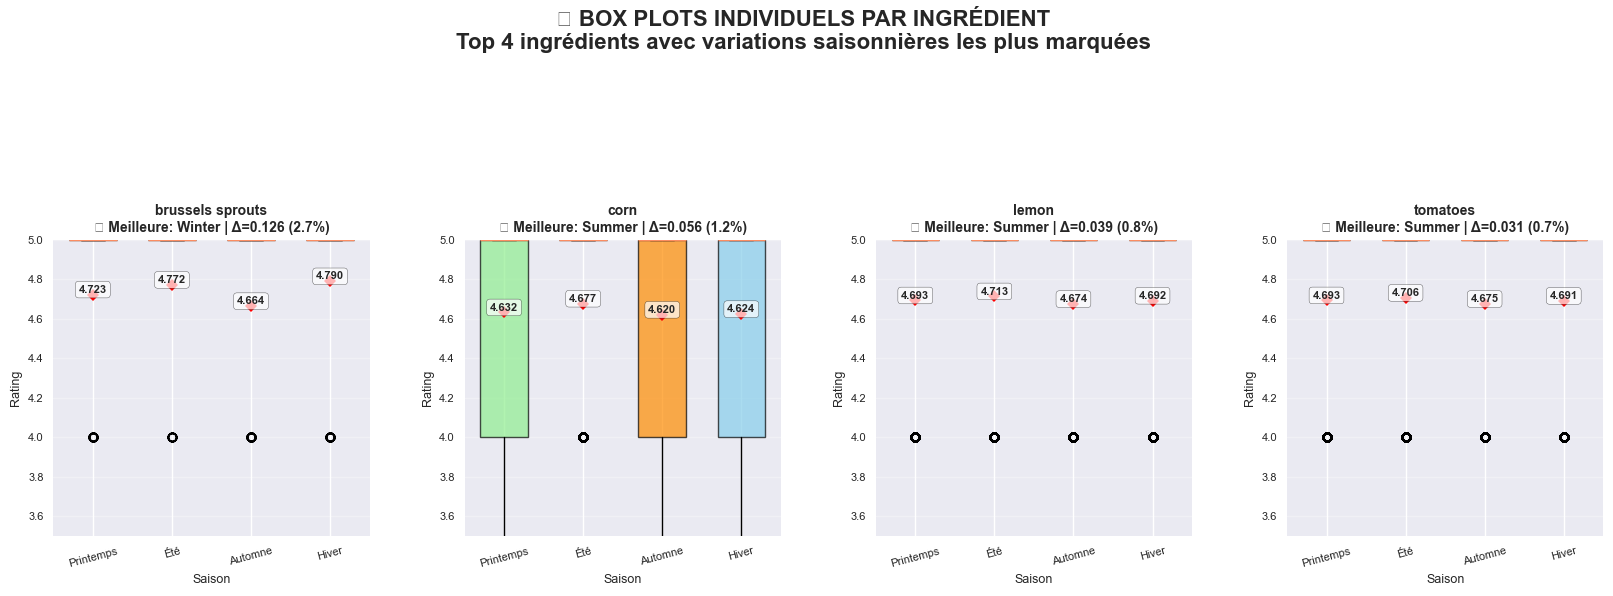

✅ Box plots individuels créés pour 4 ingrédients


In [10]:
# 📦 BOX PLOTS INDIVIDUELS - GridSpec 4×4 pour Top 16 Ingrédients
print('📦 Création des box plots individuels par ingrédient...')

if len(significant_seasonal) > 0:
    # Sélection des top 16 ingrédients les plus variables
    top_ingredients = significant_seasonal.sort('seasonal_range', descending=True).head(16)['ingredient'].to_list()
    
    # Création de la figure avec GridSpec 4×4
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)
    
    for idx, ingredient in enumerate(top_ingredients):
        row = idx // 4
        col = idx % 4
        ax = fig.add_subplot(gs[row, col])
        
        # Données pour cet ingrédient
        ingredient_data = df.filter(pl.col('ingredient_name') == ingredient)
        plot_data = ingredient_data.select(['season', 'rating']).to_pandas()
        
        # Récupération des statistiques ANOVA
        ingredient_stats = anova_df.filter(pl.col('ingredient') == ingredient).row(0, named=True)
        
        # Box plot avec couleurs saisonnières
        seasons_ordered = ['Printemps', 'Été', 'Automne', 'Hiver']
        bp = ax.boxplot([plot_data[plot_data['season'] == s]['rating'].values 
                         for s in seasons_ordered if s in plot_data['season'].values],
                        labels=[s for s in seasons_ordered if s in plot_data['season'].values],
                        patch_artist=True,
                        widths=0.6,
                        showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=6))
        
        # Coloration des box plots
        for patch, season in zip(bp['boxes'], [s for s in seasons_ordered if s in plot_data['season'].values]):
            patch.set_facecolor(SEASON_COLORS.get(season, '#666666'))
            patch.set_alpha(0.7)
        
        # Ajout des moyennes saisonnières
        season_means = plot_data.groupby('season')['rating'].mean()
        for i, season in enumerate([s for s in seasons_ordered if s in plot_data['season'].values]):
            if season in season_means.index:
                mean_val = season_means[season]
                ax.text(i+1, mean_val, f'{mean_val:.3f}', 
                       ha='center', va='bottom', fontweight='bold', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        # Identification de la meilleure saison avec emoji
        best_season = ingredient_stats['best_season']
        season_emojis = {'Printemps': '🌱', 'Été': '☀️', 'Automne': '🍂', 'Hiver': '❄️'}
        best_emoji = season_emojis.get(best_season, '🌿')
        
        # Calcul du % change total
        all_means = [ingredient_stats['spring_avg'], ingredient_stats['summer_avg'], 
                    ingredient_stats['autumn_avg'], ingredient_stats['winter_avg']]
        pct_change = (max(all_means) - min(all_means)) / min(all_means) * 100
        
        # Titre avec statistiques
        ax.set_title(f'{ingredient}\n{best_emoji} Meilleure: {best_season} | Δ={ingredient_stats["seasonal_range"]:.3f} ({pct_change:.1f}%)',
                    fontsize=10, fontweight='bold')
        ax.set_ylabel('Rating', fontsize=9)
        ax.set_xlabel('Saison', fontsize=9)
        ax.tick_params(axis='x', labelsize=8, rotation=15)
        ax.tick_params(axis='y', labelsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(3.5, 5.0)
        
        # Annotation p-value si très significatif
        if ingredient_stats['p_value'] < 0.001:
            ax.text(0.95, 0.95, '***', transform=ax.transAxes,
                   fontsize=16, fontweight='bold', color='red',
                   ha='right', va='top')
    
    plt.suptitle('📦 BOX PLOTS INDIVIDUELS PAR INGRÉDIENT\n' +
                f'Top {len(top_ingredients)} ingrédients avec variations saisonnières les plus marquées',
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.show()
    print(f'✅ Box plots individuels créés pour {len(top_ingredients)} ingrédients')
    
else:
    print('⚠️  Aucune variation saisonnière significative pour box plots')